In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deem import deem

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    openmic_class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: 
    class_align = json.load(f)

with open("genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

# Load embeddings and align classes

In [3]:
embedding = 'vggish'
debias_method = ''

deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='./embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid, class_align=class_align)

(X_train_irmas, Y_train_irmas), (X_test_irmas, Y_test_irmas), (genre_train_irmas, genre_test_irmas) = deb.load_irmas()
(X_train_openmic, Y_train_openmic), (X_test_openmic, Y_test_openmic), \
(Y_mask_train, Y_mask_test), (genre_train_openmic, genre_test_openmic) = deb.load_openmic()

(13410, 128) (13410,)
(6705,)


100%|██████████| 6705/6705 [00:01<00:00, 4417.58it/s]


(6705, 128) (6705,)
(180000, 128) (180000,)


100%|██████████| 20000/20000 [01:08<00:00, 289.97it/s]


(20000, 128) (20000,)
(20000, 20) (20000, 20) (20000,)


100%|██████████| 20000/20000 [00:18<00:00, 1081.67it/s]


(20000, 128) (20000, 20) (20000, 20)
# Train: 14915,  # Test: 5085


100%|██████████| 5085/5085 [00:00<00:00, 31903.60it/s]


In [4]:
cl.Counter(Y_train_irmas)

Counter({'guitar': 1051,
         'piano': 551,
         'trumpet': 427,
         'violin': 437,
         'voice': 545,
         'clarinet': 378,
         'saxophone': 476,
         'flute': 330,
         'cello': 294,
         'organ': 508})

In [5]:
cl.Counter(genre_train_openmic)

Counter({'pop_rock': 2996,
         'country_folk': 1573,
         'jazz_blue': 1247,
         'classical': 1022})

In [6]:
cl.Counter(genre_train_irmas)

Counter({'pop_rock': 1853,
         'classical': 1240,
         'jazz_blue': 1539,
         'country_folk': 365})

# data composition

In [7]:
# check data amount
openmic_inst = []
openmic_noninst = []
openmic_inst_genre = {inst:[] for inst in instrument_map}
irmas_inst = []
irmas_noninst = []
irmas_inst_genre = {inst:[] for inst in instrument_map}

for instrument in instrument_map:
    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = openmic_class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    genre_train_inst_openmic = genre_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    genre_train_inst_irmas = genre_train_irmas
    X_test_inst_irmas = X_test_irmas

    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_train_noninst_irmas = Y_train_irmas!=instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    ###### classification ######
    X_train_inst_openmic_true = X_train_inst_openmic[Y_train_inst_openmic]
    X_train_inst_openmic_false = X_train_inst_openmic[Y_train_noninst_openmic]

    X_train_inst_irmas_true = X_train_inst_irmas[Y_train_inst_irmas]
    X_train_inst_irmas_false = X_train_inst_irmas[Y_train_noninst_irmas]

    genre_train_inst_openmic_true = genre_train_inst_openmic[Y_train_inst_openmic]
    genre_train_inst_openmic_false = genre_train_inst_openmic[Y_train_noninst_openmic]

    genre_train_inst_irmas_true = genre_train_inst_irmas[Y_train_inst_irmas]
    genre_train_inst_irmas_false = genre_train_inst_irmas[Y_train_noninst_irmas]

    dim_inst = min(X_train_inst_openmic_true.shape[0], X_train_inst_irmas_true.shape[0])
    dim_noninst = min(X_train_inst_openmic_false.shape[0], X_train_inst_irmas_false.shape[0])

    X_train_inst_openmic_true, genre_train_inst_openmic_true = \
        deb.resample_data(X_train_inst_openmic_true, genre_train_inst_openmic_true, dim_inst)
    X_train_inst_irmas_true, genre_train_inst_irmas_true = \
        deb.resample_data(X_train_inst_irmas_true, genre_train_inst_irmas_true, dim_inst)

    X_train_inst_openmic_false, genre_train_inst_openmic_false = \
        deb.resample_data(X_train_inst_openmic_false, genre_train_inst_openmic_false, dim_noninst)
    X_train_inst_irmas_false, genre_train_inst_irmas_false = \
        deb.resample_data(X_train_inst_irmas_false, genre_train_inst_irmas_false, dim_noninst)
    
    X_train_inst_irmas = np.vstack((X_train_inst_irmas_true, X_train_inst_irmas_false))
    Y_train_inst_irmas = np.array([[True] * len(X_train_inst_irmas_true) + [False] * len(X_train_inst_irmas_false)]).reshape(-1,)
    genre_train_inst_irmas = np.hstack((genre_train_inst_irmas_true, genre_train_inst_irmas_false))

    X_train_inst_openmic = np.vstack((X_train_inst_openmic_true, X_train_inst_openmic_false))
    Y_train_inst_openmic = np.array([[True] * len(X_train_inst_openmic_true) + [False] * len(X_train_inst_openmic_false)]).reshape(-1,)
    genre_train_inst_openmic = np.hstack((genre_train_inst_openmic_true, genre_train_inst_openmic_false))

    openmic_inst.append(X_train_inst_openmic_true.shape[0])
    openmic_noninst.append(X_train_inst_openmic_false.shape[0])
    irmas_inst.append(X_train_inst_irmas_true.shape[0])
    irmas_noninst.append(X_train_inst_irmas_false.shape[0])

    openmic_inst_genre[instrument] = genre_train_inst_openmic_true
    irmas_inst_genre[instrument] = genre_train_inst_irmas_true

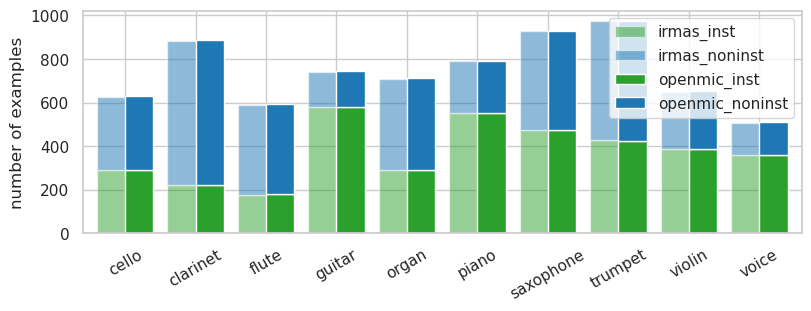

In [8]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.constrained_layout.use'] = True
df = pd.DataFrame({'instrument': list(instrument_map), 
                    'openmic_inst': openmic_inst,
                    'openmic_noninst': openmic_noninst,
                    'irmas_inst': irmas_inst,
                    'irmas_noninst': irmas_noninst})

fig, ax = plt.subplots(figsize=(8,3))
# colors = ['#0271AE', '#DC2830']
colors = ['tab:green', 'tab:blue']
# colors = ['green', 'blue', 'tab:green', 'tab:blue']
df.plot(stacked=True, kind='bar', x='instrument', y=['irmas_inst','irmas_noninst'], ax=ax, position=1, width=0.4, color=colors, alpha=.5)
df.plot(stacked=True, kind='bar', x='instrument', y=['openmic_inst','openmic_noninst'], ax=ax, position=0, width=0.4, color=colors)
plt.xlim([-.6, len(df) - .4])
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('number of examples')
plt.savefig('results/train_set_distribution.pdf', bbox_inches='tight')

In [9]:
with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)

In [10]:
genre_info = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])

for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(irmas_inst_genre[inst][irmas_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['irmas'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)
    
for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(openmic_inst_genre[inst][openmic_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['openmic'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)

In [11]:
genre_info[:10]

,instrument,genre,examples,train_set
0,cello,pop_rock,82,irmas
1,cello,jazz_blue,22,irmas
2,cello,classical,184,irmas
3,cello,country_folk,0,irmas
0,clarinet,pop_rock,58,irmas
1,clarinet,jazz_blue,61,irmas
2,clarinet,classical,102,irmas
3,clarinet,country_folk,0,irmas
0,flute,pop_rock,56,irmas
1,flute,jazz_blue,51,irmas


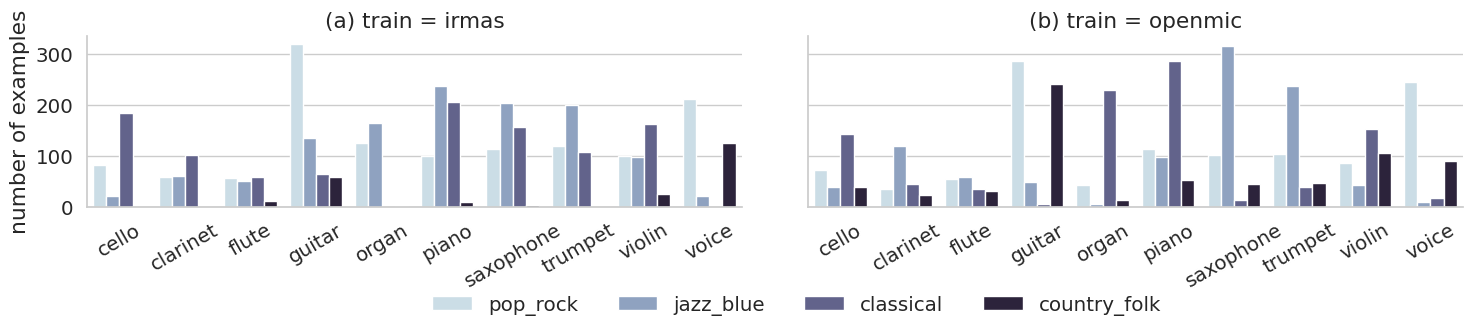

In [12]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)

ax = sns.catplot(data=genre_info, col='train_set', x='instrument', y='examples', hue='genre', kind='bar', height=3, aspect=2.5,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
# a0.set_ylim([0,400])
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
# a1.set_ylim([0,400])

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.15), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
# plt.title('Genre information per instrument')
plt.savefig('results/genre_information.pdf', bbox_inches='tight')

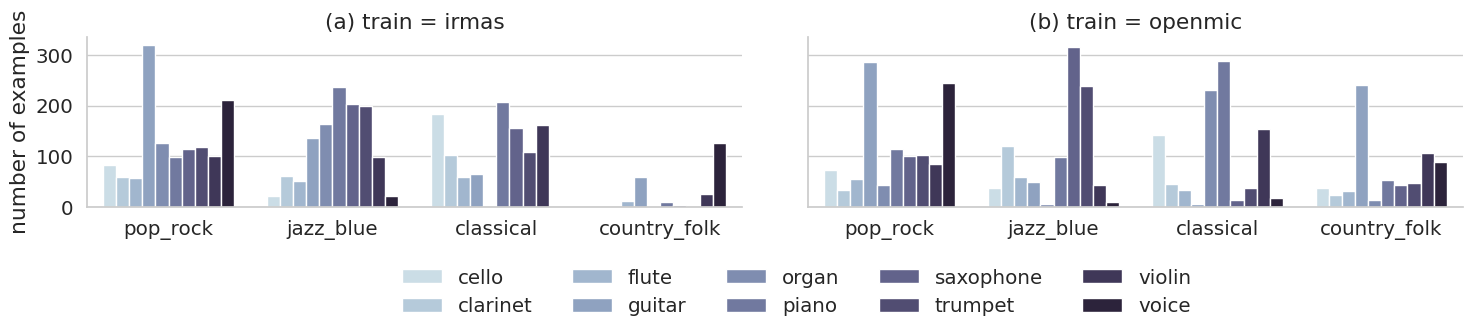

In [13]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)

ax = sns.catplot(data=genre_info, col='train_set', x='genre', y='examples', hue='instrument', kind='bar', height=3, aspect=2.5,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
# a0.set_ylim([0,400])
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
# a1.set_ylim([0,400])

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.15), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
# ax.set_xticklabels(rotation=30)
# plt.title('Genre information per instrument')
# plt.savefig('results/genre_information_instrument.pdf', bbox_inches='tight')